
#### Specify Jupyter extensions

`matplotlib` inline allows visualizing the plots in the notebook. `autoreload` allows external modules to be reloaded automatically to keep track of any changes made therein.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import the Python libraries and custom modules as needed¶

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm

# Import scikit-learn for functions and datasets.
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix

# Import OpenCV to save the weights as frames of a video.
import cv2

# Import the custom module for helper functions
from utils import *

In [3]:
# Specifying seed value for reproducibility.

seedval = 8888
np.random.seed(seedval)

In [4]:
# Specifying project directories.

savedir = 'SavedFigs/'

# Question 2

## Loading, validating, and exploring the dataset

In [5]:
mnist_data = fetch_openml('mnist_784', version=1, return_X_y=False)

data, target = mnist_data.data.to_numpy(), mnist_data.target.astype(np.int_).to_numpy()

print("Shape of input data:", data.shape)
print("Shape of target labels:", target.shape)

Shape of input data: (70000, 784)
Shape of target labels: (70000,)


In [6]:
# We want to count the sample population of each target label in the dataset.

print("Class-wise sample counts")

# For every label, count the number of occurrences of it in the dataset.
for label in range(10):
    # Since the labels in this dataset are strings, we convert them to 
    # integers first.
    print(label, '->' , len(np.where(target.astype(np.int_) == label)[0]))

Class-wise sample counts
0 -> 6903
1 -> 7877
2 -> 6990
3 -> 7141
4 -> 6824
5 -> 6313
6 -> 6876
7 -> 7293
8 -> 6825
9 -> 6958


## Select the 4 classes based on user inputs `class0`, `class1`, `class2`, and `class3`

In [7]:
class0, class1, class2, class3 = 0, 1, 3, 4

In [8]:
# Save the classes in a list and infer the number of classes.

classes = [class0, class1, class2, class3]
n_classes = len(classes)

## Partition the dataset into training and testing splits

In [9]:
# Specify the percentage of the dataset to be held out for testing
test_frac = 0.3

In [10]:
x_train, x_test, y_train, y_test = prepare_data(X=data, 
                                                Y=target, 
                                                class0=class0, 
                                                class1=class1, 
                                                class2=class2, 
                                                class3=class3, 
                                                test_split_fraction=test_frac, 
                                                seedval=seedval)

print('Training partition input data shape:', x_train.shape)
print('Training partition labels shape:', y_train.shape)
print('Testing partition input data shape:', x_test.shape)
print('Testing partition labels shape:', y_test.shape)

# Infer the number of data points in training and testing partitions
# and the number of features from the shape
n_train, n_test, n_feats = x_train.shape[0], x_test.shape[0], x_train.shape[1]

Training partition input data shape: (20121, 784)
Training partition labels shape: (20121,)
Testing partition input data shape: (8624, 784)
Testing partition labels shape: (8624,)


## Train a softmax regression classifier for multi-class classification using mini-batch stochastic gradient descent and hyperparameter optimization

### Feature normalization

In [11]:
# Normalize the input data to [0, 1] by dividing by 255.
x_train_norm, x_test_norm = x_train / 255., x_test / 255.

### Defining the set of values over which hyperparameter optimization is to be performed

In [12]:
lr_vals = [1, 5e-1, 1e-1]         # set of learning rate values to choose from
reg_param_vals = [1, 0.1, 0.]     # set of regularization parameter values to choose from
batch_size_vals = [1000, 5000]    # set of batch size values to choose from
n_epochs_vals = [50, 100, 200]    # set of training epochs to choose from

### Perform a grid search over the hyperparameter values with K-fold cross validation

In [13]:
# Define a classifier with some hyperparameter values. This is necessary to initialize
# the classifier object. However, these are just placeholder values and we will 
# perform a grid search to choose the best set of values.
clsfr = SoftmaxClassifier(n_features=784, 
                          n_classes=4, 
                          reg_param=0.1, 
                          lr=1e-3, 
                          batch_size=50, 
                          n_epochs=1000)

# We then initialize a dictionary with the set of possible hyperparameter values so
# that we can perform a grid search over them.
# Inspired by https://bit.ly/3xDCKwa
hyperparam_grid = dict(lr=lr_vals, 
                       reg_param=reg_param_vals, 
                       batch_size=batch_size_vals, 
                       n_epochs=n_epochs_vals)

# Next, we define a K-fold cross validation with K = 3 to select the best set of 
# hyperparameter values.
# We set shuffle=True so that the data is shuffled before each 3-fold split.
KFold_cv = KFold(n_splits=3, shuffle=True, random_state=seedval)

# We choose the classification accuracy as the scoring function.
# We set n_jobs=-1 to utilize all the CPU cores and reduce computation time.
# We set error_score=0 to substitute 0 in case the error function cannot be
# calculated for a split.
GridSearch_KFold_cv = GridSearchCV(estimator=clsfr, 
                                   param_grid=hyperparam_grid, 
                                   n_jobs=-1, 
                                   cv=KFold_cv, 
                                   scoring='accuracy', 
                                   error_score=0)

# Finally, we perform the grid search operation. This will take some time
# to complete since we are fitting 162 models 
# (54 sets of hyperparameters * 3-fold cross validation = 162 models)
GridSearch_KFold_cv_result = GridSearch_KFold_cv.fit(x_train_norm, y_train)

In [14]:
# We print the best set of hyperparameter values
print(f'The best cross validation classification accuracy is {GridSearch_KFold_cv_result.best_score_:.4f} using')

for key in GridSearch_KFold_cv_result.best_params_.keys():
    print(key, ':', GridSearch_KFold_cv_result.best_params_[key])

The best cross validation classification accuracy is 0.9879 using
batch_size : 1000
lr : 0.5
n_epochs : 200
reg_param : 0.1


0.9857 (0.0014) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 50, 'reg_param': 1}
0.9869 (0.0020) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 50, 'reg_param': 0.1}
0.9865 (0.0019) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 50, 'reg_param': 0.0}
0.9862 (0.0012) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 100, 'reg_param': 1}
0.9878 (0.0016) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 100, 'reg_param': 0.1}
0.9874 (0.0020) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 100, 'reg_param': 0.0}
0.9862 (0.0013) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 200, 'reg_param': 1}
0.9875 (0.0012) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 200, 'reg_param': 0.1}
0.9869 (0.0014) with: {'batch_size': 1000, 'lr': 1, 'n_epochs': 200, 'reg_param': 0.0}
0.9851 (0.0018) with: {'batch_size': 1000, 'lr': 0.5, 'n_epochs': 50, 'reg_param': 1}
0.9854 (0.0021) with: {'batch_size': 1000, 'lr': 0.5, 'n_epochs': 50, 'reg_param': 0.1}
0.9853 (0.0020) with: {'batch_size': 1000, 'lr': 0.5

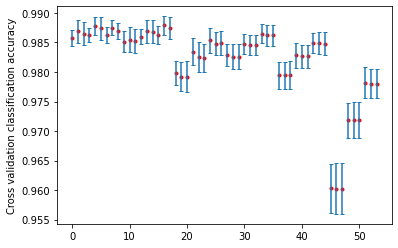

In [15]:
# Next, we print and visualize the performance of all the sets of 
# hyperparameter values.

grid_means = GridSearch_KFold_cv_result.cv_results_['mean_test_score']
grid_stds = GridSearch_KFold_cv_result.cv_results_['std_test_score']
grid_params = GridSearch_KFold_cv_result.cv_results_['params']
for mean, stdev, param in zip(grid_means, grid_stds, grid_params):
    print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    
# For visualizing, we plot each hyperparameter value set's 
# classification accuracy and denote the variation between the 
# 3 folds as error bars.
plt.scatter(np.arange(0, 54, 1), grid_means, color='r', marker='.')
plt.errorbar(np.arange(0, 54, 1), grid_means, grid_stds, linestyle='None', capsize=2)
plt.ylabel('Cross validation classification accuracy')
# plt.savefig(savedir + 'Q2_1.png', dpi=300, bbox_inches='tight')
plt.show()

### Training the classifier with the best hyperparameters

In [16]:
# Initialize a classifier with the hyperparameters set to the values
# calculated above.

train_epochs = GridSearch_KFold_cv_result.best_params_['n_epochs']

clsfr = SoftmaxClassifier(n_features=n_feats, 
                          n_classes=n_classes, 
                          reg_param=GridSearch_KFold_cv_result.best_params_['reg_param'], 
                          lr=GridSearch_KFold_cv_result.best_params_['lr'], 
                          batch_size=GridSearch_KFold_cv_result.best_params_['batch_size'], 
                          n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats, n_classes)), np.zeros((train_epochs, n_classes))

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train_norm, y_train, calculate_loss=True)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch, ...], params['b'][epoch, ...] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train_norm, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test_norm, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

### Plotting the classifier's loss and accuracy over the course of training

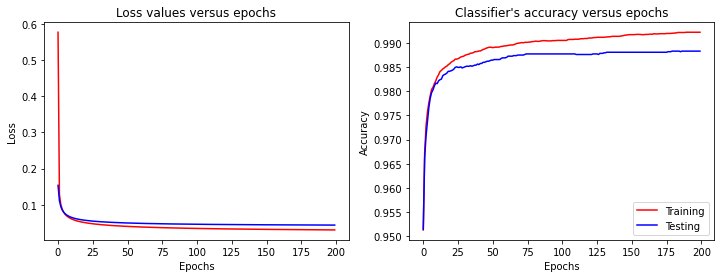

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_2.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualize the classifier's parameters

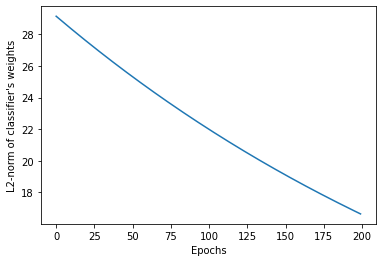

In [18]:
# Calculate the L2-norm of the classifier's weights for all 
# epochs and plot it.
params_W_L2_norm = np.array([norm(params['W'][idx], 2)
                             for idx in range(train_epochs)])
plt.plot(params_W_L2_norm)
plt.xlabel('Epochs')
plt.ylabel('L2-norm of classifier\'s weights')
# plt.savefig(savedir + 'Q2_3.png', dpi=300, bbox_inches='tight')
plt.show()

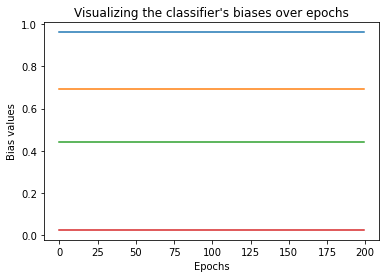

In [19]:
# Similarly, we will visualize the model's bias over epochs.

plt.plot(params['b'])
plt.xlabel('Epochs')
plt.ylabel('Bias values')
plt.title('Visualizing the classifier\'s biases over epochs')
# plt.savefig(savedir + 'Q2_4.png', dpi=300, bbox_inches='tight')
plt.show()

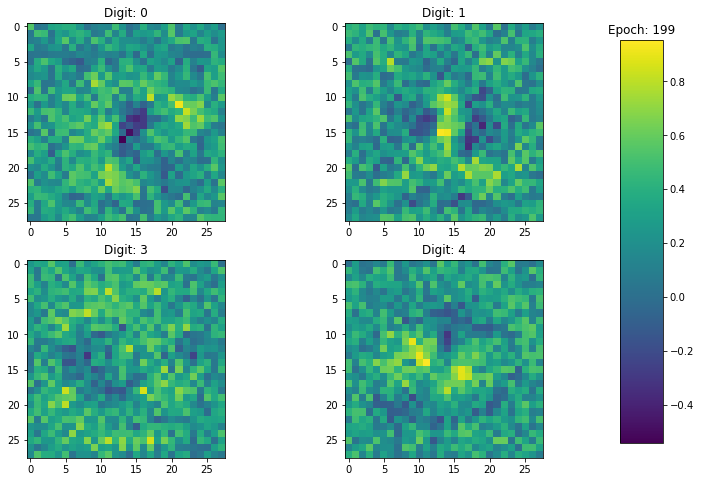

In [20]:
# Finally, we visualize the model weights as an animation composed of
# a 2 x 2 grid of 28 x 28 images, each image corresponding to the 
# weights from an epoch.

# We will save the weights as images first, one image for each epoch.
for epoch in range(train_epochs):
    # Close any open plots.
    plt.close()
    # Create a 2 x 2 grid to plot the 4 weight map images in.
    fig, axs = plt.subplots(2, 2, figsize=(12,8))

    # Iterate over the classes.
    for cls_idx in range(n_classes):
        # Calculate the position in the grid based on the class index.
        axs_row, axs_col = (cls_idx // 2), (cls_idx % 2)
        # Calculate the minimum and maximum weight values for each 
        # epoch. This is used to choose the color for the image.
        epoch_val_max, epoch_val_min = params['W'][epoch,...].max(), params['W'][epoch,...].min()
        # Finally, plot each weight map with the 'viridis' colormap
        # and colors defined by min and max values calculated above.
        im = axs[axs_row][axs_col].imshow(params['W'][epoch,:,cls_idx].reshape(28,28), 
                                          cmap='viridis', 
                                          vmin=epoch_val_min, 
                                          vmax=epoch_val_max
                                         )
        # Assign a title to each subplot.
        axs[axs_row][axs_col].set_title(f'Digit: {classes[cls_idx]}')

    # Add a colorbar to explain the weight map colors.
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, aspect=50)
    plt.title('Epoch: {:03d}'.format(epoch))
    plt.savefig(savedir + 'VideoFrames/wts_{:03d}'.format(epoch), dpi=300, bbox_inches='tight')
    
# Store the filenames of all the saved frames.
imgs = [savedir + 'VideoFrames/' + f 
        for f in sorted(os.listdir(savedir + 'VideoFrames/')) 
        if f.endswith('.png')]

# Initialize an empty list to store all the frames.
img_array = []

# Iterate over each image to store it in the list.
for f in imgs:
    # Open each image with OpenCV.
    img = cv2.imread(f)
    # Infer image height and width from shape.
    height, width, _ = img.shape
    # Define image size using height and width above.
    size = (width, height)
    # Append the image to the list.
    img_array.append(img)
    
# Initialize an OpenCV VideoWriter object to save the frames as a video.
# We set the frame rate of the video to 15 fps.
# Inspired by https://bit.ly/3vPyPuU
out = cv2.VideoWriter(savedir + 'Q2_5.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

# Interate over each image in the list and write it as a frame of 
# the video.
for idx in range(len(img_array)):
    out.write(img_array[idx])

# Close the VideoWriter object.
out.release()

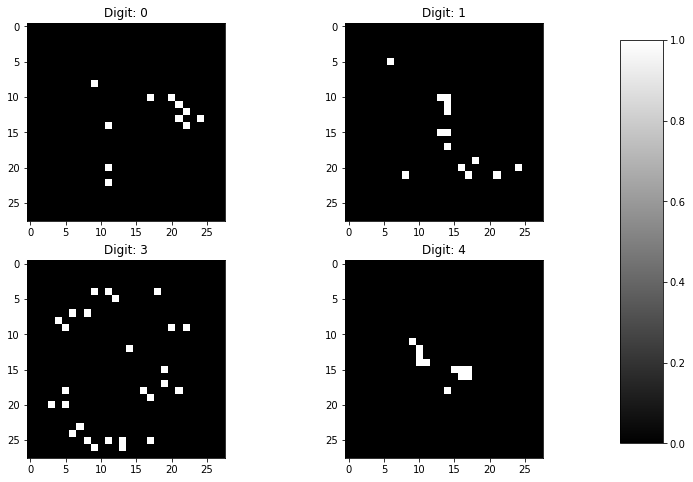

In [21]:
# Next, we extract and visualize the most discriminative pixels in
# each weight map. This helps us better understand which locations
# lead to classification decisions.

# Create a 2 x 2 grid to plot the 4 weight map images in.
fig, axs = plt.subplots(2, 2, figsize=(12,8))

# Iterate over the classes.
for cls_idx in range(n_classes):
    # Extract the weight maps from the last epoch of training, and
    # reshape it to a 28 x 28 image.
    cls_wt = params['W'][-1,:,cls_idx].reshape(28,28)
    # For each weight map, set a threshold of 0.75, so that only 
    # those pixels with values more than 0.75 times the max value
    # are set as white, and all the other pixels are black.
    im = axs[cls_idx // 2][cls_idx % 2].imshow((cls_wt > cls_wt.max()*0.75), cmap='gist_gray')
    # Assign a title to each subplot.
    axs[cls_idx // 2][cls_idx % 2].set_title(f'Digit: {classes[cls_idx]}')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, aspect=50)
# plt.savefig(savedir + 'Q2_6.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluate the classifier on the test split of the dataset

### Confusion matrix of the classifier

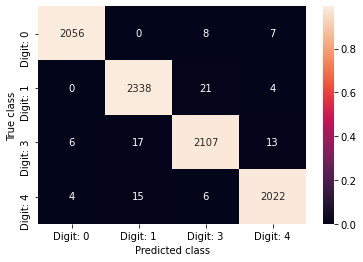

In [22]:
# Construct the confusion matrix of the classifier using the 
# predicted and the ground truth labels of the test split.
confmat = confusion_matrix(y_true=y_test, y_pred=pred_test)
# Normalize the confusion matrix row-wise so that each row
# is colored according to the number of data points 
# predicted.
confmat_norm = confmat/confmat.sum(axis=1)

# Set x-tick and y-tick labels for the plot.
confmat_ticklabels = [f'Digit: {cls}' for cls in classes]

# Create a seaborn heatmap to visualize the confusion matrix
# of the classifier on the test set.
# fmt="g" enforces integer output in each cell.
confmat_heatmap = sns.heatmap(confmat_norm, 
                              annot=confmat, 
                              fmt="g", 
                              xticklabels=confmat_ticklabels, 
                              yticklabels=confmat_ticklabels)

# Set axis labels for the confusion matrix.
confmat_heatmap.set(xlabel="Predicted class",
                    ylabel="True class")

confmat_fig = confmat_heatmap.get_figure()    
# confmat_fig.savefig(savedir + 'Q2_7.png', dpi=300, bbox_inches='tight')

### Classification performance metrics

In [23]:
# Calculate the classification metrics for each class in the
# test split of the dataset.
# output_dict=True ensures that this returns a dict.

clsfr_metrics = classification_report(y_true=y_test, 
                                      y_pred=pred_test, 
                                      target_names=confmat_ticklabels, 
                                      output_dict=True)

# Print the precision, the recall, and the F1-score of each 
# class as well as the macro-average for the entire test 
# split.
print('Class\t\tPrecision\tRecall\t\tF1-score')
for cls in confmat_ticklabels:
    print('{:s}\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(cls, 
                                               clsfr_metrics[cls]['precision'], 
                                               clsfr_metrics[cls]['recall'], 
                                               clsfr_metrics[cls]['f1-score']))

print('Average\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(clsfr_metrics['macro avg']['precision'], 
                                                     clsfr_metrics['macro avg']['recall'], 
                                                     clsfr_metrics['macro avg']['f1-score']))

Class		Precision	Recall		F1-score
Digit: 0	0.9952		0.9928		0.9940
Digit: 1	0.9865		0.9894		0.9880
Digit: 3	0.9837		0.9832		0.9834
Digit: 4	0.9883		0.9878		0.9880
Average		0.9884		0.9883		0.9883
